# **:BLOQUE 1 – Instalación**

In [2]:
# BLOQUE 1 - Instalación de librerías (solo en Colab)
!pip install -q kagglehub pandas scikit-learn geopandas folium shapely catboost xgboost



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# **BLOQUE 2 – Descarga, carga, cleaning básico + CABA geográfica + outliers**

In [1]:
# BLOQUE 2 - Descarga de dataset, carga, cleaning básico y recorte a CABA

import os
import glob
import shutil
import numpy as np
import pandas as pd
import kagglehub
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

# =====================================================
# 1) Descargar dataset de Kaggle y consolidar CSVs
# =====================================================
path = kagglehub.dataset_download("alejandroczernikier/properati-argentina-dataset")
print("Path to dataset files:", path)

dest = "data/"
os.makedirs(dest, exist_ok=True)
for file in os.listdir(path):
    shutil.copy(os.path.join(path, file), os.path.join(dest, file))

files = glob.glob(os.path.join(dest, "*.csv"))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

print("Shape inicial:", df.shape)
print("Columnas:", df.columns.tolist())

# =====================================================
# 1.b) Corregir nombres de lat/lon (vienen invertidos)
# =====================================================
# En el origen: 'lat' es la longitud y 'lon' es la latitud.
# Los swappeamos para que:
#   - df['lat'] = verdadera latitud
#   - df['lon'] = verdadera longitud
tmp_lat = df["lat"].copy()
df["lat"] = df["lon"]
df["lon"] = tmp_lat

# (Opcional) chequeo rápido de rangos
print("Rango lat:", df["lat"].min(), "→", df["lat"].max())
print("Rango lon:", df["lon"].min(), "→", df["lon"].max())

# =====================================================
# 2) Filtros iniciales (solo ventas, precio válido, CABA)
# =====================================================

# Filtro por tipo de operación si existe la columna
if "operation_type" in df.columns:
    df = df[df["operation_type"] == "Venta"]

# Precio positivo
df = df[df["price"] > 0]

# Solo Capital Federal (CABA) según l2 si existe
if "l2" in df.columns:
    df = df[df["l2"] == "Capital Federal"]

# =====================================================
# 3) Limpieza de precios "truchos" + conversión ARS→USD 2019/2020
# =====================================================

precios_invalidos = [111111111, 11]
df = df[~df["price"].isin(precios_invalidos)]

# Aseguramos que start_date sea datetime si existe
if "start_date" in df.columns:
    df["start_date"] = pd.to_datetime(df["start_date"], errors="coerce")

    mask_2019_ars = (df["currency"] == "ARS") & (df["start_date"].dt.year == 2019)
    mask_2020_ars = (df["currency"] == "ARS") & (df["start_date"].dt.year == 2020)

    # Conversión de precio (ARS a USD aprox)
    df.loc[mask_2019_ars, "price"] = df.loc[mask_2019_ars, "price"] / 80
    df.loc[mask_2020_ars, "price"] = df.loc[mask_2020_ars, "price"] / 195

    df.loc[mask_2019_ars | mask_2020_ars, "currency"] = "USD"

print("Shape tras filtros básicos y conversión:", df.shape)

# =====================================================
# 4) Eliminar columnas que no usaremos (pero conservamos id y l3)
# =====================================================

cols_drop = [
    "l1", "ad_type", "l4", "l5", "l6",
    "title", "description", "price_period",
    "operation_type", "start_date", "end_date",
    "created_on", "currency", "l2"
]

cols_to_drop_existing = [c for c in cols_drop if c in df.columns]
df = df.drop(columns=cols_to_drop_existing)

print("Shape tras drop columnas:", df.shape)
print("Columnas actuales:", df.columns.tolist())

# =====================================================
# 5) Geofiltrado: solo puntos dentro del polígono oficial de CABA
# =====================================================

print("Filas antes de lat/lon:", len(df))

# Dropear registros sin coordenadas
df = df.dropna(subset=["lat", "lon"])
print("Filas luego de eliminar lat/lon vacíos:", len(df))

# Cargar comunas CABA (archivo local caba.json)
caba = gpd.read_file("caba.json")

# Asegurar CRS compatible (EPSG:4326)
if caba.crs is not None and caba.crs.to_string() != "EPSG:4326":
    caba = caba.to_crs("EPSG:4326")

# Unión de polígonos
try:
    caba_union = caba.unary_union
except AttributeError:
    # Fallback por compatibilidad
    caba_union = caba.geometry.unary_union

# Crear GeoDataFrame (x = lon, y = lat)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

# Flag: si el punto cae dentro de CABA
gdf["inside_caba"] = gdf.within(caba_union)

fuera = gdf[~gdf["inside_caba"]]
print("Puntos fuera de CABA:", len(fuera))

gdf_caba = gdf[gdf["inside_caba"]].copy()
print("Filas finales dentro de CABA:", len(gdf_caba))

# Guardar CSV limpio para validación / otros usos
gdf_caba_no_geom = gdf_caba.drop(columns=["geometry", "inside_caba"])
gdf_caba_no_geom.to_csv("caba_geo_clean.csv", index=False)
print("Nuevo dataset guardado: caba_geo_clean.csv")

# =====================================================
# 6) Mapa de validación (Folium)
# =====================================================

mapa = gdf_caba_no_geom.copy()

m = folium.Map(location=[-34.60, -58.44], zoom_start=11, tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(m)

# Para no explotar el mapa si hay muchos puntos, hacemos sample
if len(mapa) > 8000:
    mapa_sample = mapa.sample(n=8000, random_state=42)
else:
    mapa_sample = mapa

for _, row in mapa_sample.iterrows():
    if pd.notnull(row["lat"]) and pd.notnull(row["lon"]):
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],  # ahora lat y lon ya están corregidos
            radius=2,
            fill=True,
            fill_opacity=0.6,
            color="red",
        ).add_to(marker_cluster)

m.save("mapa_validacion_caba.html")
print("Mapa generado: mapa_validacion_caba.html")

# =====================================================
# 7) Limpieza numérica fuerte + outliers por tipo + solo residenciales
# =====================================================

df_clean = gdf_caba_no_geom.copy()
print("Shape inicial para limpieza numérica:", df_clean.shape)

num_cols = ["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"]

# Asegurar valores numéricos
for col in num_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

before_incoh = len(df_clean)

# surface_total > 0 (o NaN)
df_clean = df_clean[df_clean["surface_total"].isna() | (df_clean["surface_total"] > 0)]

# surface_covered >= 0
df_clean = df_clean[df_clean["surface_covered"].isna() | (df_clean["surface_covered"] >= 0)]

# surface_covered <= surface_total
mask_rel = (
    df_clean["surface_covered"].isna() |
    df_clean["surface_total"].isna() |
    (df_clean["surface_covered"] <= df_clean["surface_total"])
)
df_clean = df_clean[mask_rel]

# rooms, bedrooms, bathrooms >= 0
for col in ["rooms", "bedrooms", "bathrooms"]:
    if col in df_clean.columns:
        df_clean = df_clean[df_clean[col].isna() | (df_clean[col] >= 0)]

print("Eliminados por incoherencias:", before_incoh - len(df_clean))
print("Shape tras incoherencias:", df_clean.shape)

# ---- Outliers por tipo de propiedad (IQR) ----
def remove_outliers_by_type(df_in, col, k=1.5):
    # Si viene vacío, devolvemos igual para evitar ValueError
    if df_in.empty:
        return df_in

    frames = []
    for ptype in df_in["property_type"].dropna().unique():
        subset = df_in[df_in["property_type"] == ptype].copy()

        Q1 = subset[col].quantile(0.25)
        Q3 = subset[col].quantile(0.75)
        IQR = Q3 - Q1

        if pd.isna(IQR) or IQR == 0:
            frames.append(subset)
            continue

        lower = Q1 - k * IQR
        upper = Q3 + k * IQR

        mask = subset[col].isna() | subset[col].between(lower, upper)
        frames.append(subset[mask])

    # Si por alguna razón no se acumuló nada, devolvemos df_in
    if not frames:
        return df_in

    return pd.concat(frames, ignore_index=True)

before_out = len(df_clean)
for col in num_cols:
    df_clean = remove_outliers_by_type(df_clean, col)
    print(f"Shape tras outliers en {col}: {df_clean.shape}")

print("Eliminados total por outliers:", before_out - len(df_clean))

# ---- Nos quedamos solo con propiedades residenciales ----
residenciales = ["Departamento", "PH", "Casa", "Casa de campo"]
df_res = df_clean[df_clean["property_type"].isin(residenciales)].copy()

print("Filas residenciales (df_res):", len(df_res))
print("Columnas df_res:", df_res.columns.tolist())



ModuleNotFoundError: No module named 'kagglehub'

BLOQUE 3b – Cross-Validation estratificada (regresión)

In [6]:
# BLOQUE 3b - Cross Validation estratificada por precio (regresión)

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

SEED = 42

# =====================================================
# 0) Partimos de df_res (definido en BLOQUE 2)
# =====================================================
df_cv = df_res.copy()

# Asegurar tipos numéricos básicos
num_cols = ["rooms", "bedrooms", "bathrooms",
            "surface_total", "surface_covered",
            "price", "lat", "lon"]

for c in num_cols:
    if c in df_cv.columns:
        df_cv[c] = pd.to_numeric(df_cv[c], errors="coerce")

# l3 vacío -> 'Desconocido'
df_cv["l3"] = df_cv["l3"].fillna("Desconocido")

# =====================================================
# 1) Limpieza global previa a CV (igual criterio que en BLOQUE 3)
# =====================================================
df_cv = df_cv[df_cv["surface_total"] > 0]
df_cv = df_cv[df_cv["price"] > 0]

precio_m2_all = df_cv["price"] / df_cv["surface_total"]
low_q, high_q = precio_m2_all.quantile([0.01, 0.99])
mask = (precio_m2_all >= low_q) & (precio_m2_all <= high_q)
df_cv = df_cv[mask].copy()

print("Filas luego de limpieza global para CV:", len(df_cv))

# =====================================================
# 2) Features base y bins para estratificación
# =====================================================
base_features = [
    "lat", "lon",
    "rooms", "bedrooms", "bathrooms",
    "surface_total", "surface_covered",
    "property_type", "l3"
]

X_all = df_cv[base_features].copy()
y_all = df_cv["price"].copy()

# Binning de precio en quintiles para hacer StratifiedKFold en regresión
# Esto balancea propiedades baratas / caras en cada fold
y_bins = pd.qcut(y_all, q=5, labels=False, duplicates="drop")

print("Cantidad de bins (quintiles) usados para estratificación:", len(np.unique(y_bins)))

# =====================================================
# 3) Función helper para construir features SIN LEAKAGE dentro de cada fold
# =====================================================
from sklearn.base import clone

def build_features_fold(X_train_base, y_train, X_val_base, n_clusters=6):
    """
    Crea:
      - precio_m2_barrio (solo con TRAIN)
      - zona_premium (solo con TRAIN)
      - cluster_geo (KMeans fit solo en TRAIN)
    Devuelve:
      X_train_xgb, X_val_xgb, X_train_cat, X_val_cat, cat_features
    """
    # ---- precio_m2_barrio ----
    train_full = X_train_base.copy()
    train_full["price"] = y_train
    train_full = train_full[train_full["surface_total"] > 0].copy()
    train_full["precio_m2_real_train"] = train_full["price"] / train_full["surface_total"]

    precio_m2_barrio_train = (
        train_full.groupby("l3")["precio_m2_real_train"]
                  .median()
    )

    X_train = X_train_base.copy()
    X_val   = X_val_base.copy()

    global_med = precio_m2_barrio_train.median()
    X_train["precio_m2_barrio"] = X_train["l3"].map(precio_m2_barrio_train).fillna(global_med)
    X_val["precio_m2_barrio"]   = X_val["l3"].map(precio_m2_barrio_train).fillna(global_med)

    # ---- zona_premium 0–3 por percentiles de precio_m2_barrio ----
    barrio_zona = pd.qcut(
        precio_m2_barrio_train,
        q=4,
        labels=[0, 1, 2, 3]
    ).astype(int)

    X_train["zona_premium"] = X_train["l3"].map(barrio_zona).fillna(1).astype(int)
    X_val["zona_premium"]   = X_val["l3"].map(barrio_zona).fillna(1).astype(int)

    # ---- cluster_geo (KMeans sobre train lat/lon) ----
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
    kmeans.fit(X_train[["lat", "lon"]])

    X_train["cluster_geo"] = kmeans.predict(X_train[["lat", "lon"]])
    X_val["cluster_geo"]   = kmeans.predict(X_val[["lat", "lon"]])

    # ============= XGBoost (one-hot) =============
    X_train_xgb = pd.get_dummies(
        X_train,
        columns=["property_type", "l3", "cluster_geo"],
        drop_first=True
    )
    X_val_xgb = pd.get_dummies(
        X_val,
        columns=["property_type", "l3", "cluster_geo"],
        drop_first=True
    )

    # Alineamos columnas
    X_train_xgb, X_val_xgb = X_train_xgb.align(X_val_xgb, join="left", axis=1, fill_value=0)

    # ============= CatBoost (categóricas nativas) =============
    X_train_cat = X_train.copy()
    X_val_cat   = X_val.copy()
    cat_features = [i for i, col in enumerate(X_train_cat.columns) if X_train_cat[col].dtype == "object"]

    return X_train_xgb, X_val_xgb, X_train_cat, X_val_cat, cat_features

# =====================================================
# 4) Definir objeto de CV estratificado
# =====================================================
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=SEED
)

metrics_xgb = []   # (MAE, RMSE, R2) por fold
metrics_cat = []

fold_num = 0

for train_idx, val_idx in skf.split(X_all, y_bins):
    fold_num += 1
    print(f"\n===== FOLD {fold_num} =====")

    X_train_base = X_all.iloc[train_idx].copy()
    X_val_base   = X_all.iloc[val_idx].copy()
    y_train      = y_all.iloc[train_idx].copy()
    y_val        = y_all.iloc[val_idx].copy()

    # Construir features sin leakage dentro del fold
    X_train_xgb, X_val_xgb, X_train_cat, X_val_cat, cat_features = build_features_fold(
        X_train_base, y_train, X_val_base, n_clusters=6
    )

    # ---------- XGBoost ----------
    xgb_model_cv = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method="hist",
        random_state=SEED
    )

    xgb_model_cv.fit(X_train_xgb, y_train)
    pred_xgb_val = xgb_model_cv.predict(X_val_xgb)

    mae_x  = mean_absolute_error(y_val, pred_xgb_val)
    rmse_x = np.sqrt(mean_squared_error(y_val, pred_xgb_val))
    r2_x   = r2_score(y_val, pred_xgb_val)
    metrics_xgb.append((mae_x, rmse_x, r2_x))

    # ---------- CatBoost ----------
    train_pool = Pool(X_train_cat, y_train, cat_features=cat_features)
    val_pool   = Pool(X_val_cat,   y_val,   cat_features=cat_features)

    cat_model_cv = CatBoostRegressor(
        depth=8,
        learning_rate=0.05,
        n_estimators=400,
        random_state=SEED,
        loss_function="RMSE",
        verbose=False  # sin spam en cada fold
    )

    cat_model_cv.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=False)
    pred_cat_val = cat_model_cv.predict(val_pool)

    mae_c  = mean_absolute_error(y_val, pred_cat_val)
    rmse_c = np.sqrt(mean_squared_error(y_val, pred_cat_val))
    r2_c   = r2_score(y_val, pred_cat_val)
    metrics_cat.append((mae_c, rmse_c, r2_c))

    print(f"XGBoost  → MAE: {mae_x:,.0f} | RMSE: {rmse_x:,.0f} | R²: {r2_x:.3f}")
    print(f"CatBoost → MAE: {mae_c:,.0f} | RMSE: {rmse_c:,.0f} | R²: {r2_c:.3f}")

# =====================================================
# 5) Métricas promedio y desviación por modelo
# =====================================================
metrics_xgb = np.array(metrics_xgb)  # shape (k, 3)
metrics_cat = np.array(metrics_cat)

def resumen_metrics(name, m):
    mae_mean, mae_std   = m[:,0].mean(), m[:,0].std()
    rmse_mean, rmse_std = m[:,1].mean(), m[:,1].std()
    r2_mean, r2_std     = m[:,2].mean(),  m[:,2].std()

    print(f"\n===== {name} - Resumen CV ({len(m)} folds) =====")
    print(f"MAE  medio: {mae_mean:,.0f}  ± {mae_std:,.0f}")
    print(f"RMSE medio: {rmse_mean:,.0f}  ± {rmse_std:,.0f}")
    print(f"R²   medio: {r2_mean:.3f}    ± {r2_std:.3f}")

resumen_metrics("XGBoost", metrics_xgb)
resumen_metrics("CatBoost", metrics_cat)


Filas luego de limpieza global para CV: 71718
Cantidad de bins (quintiles) usados para estratificación: 5

===== FOLD 1 =====
XGBoost  → MAE: 20,502 | RMSE: 33,285 | R²: 0.896
CatBoost → MAE: 25,873 | RMSE: 38,686 | R²: 0.859

===== FOLD 2 =====
XGBoost  → MAE: 20,607 | RMSE: 34,487 | R²: 0.895
CatBoost → MAE: 25,786 | RMSE: 39,915 | R²: 0.859

===== FOLD 3 =====
XGBoost  → MAE: 20,700 | RMSE: 35,791 | R²: 0.893
CatBoost → MAE: 26,103 | RMSE: 42,801 | R²: 0.846

===== FOLD 4 =====
XGBoost  → MAE: 20,078 | RMSE: 33,138 | R²: 0.902
CatBoost → MAE: 25,898 | RMSE: 39,171 | R²: 0.863

===== FOLD 5 =====
XGBoost  → MAE: 20,698 | RMSE: 34,109 | R²: 0.890
CatBoost → MAE: 26,252 | RMSE: 39,146 | R²: 0.855

===== XGBoost - Resumen CV (5 folds) =====
MAE  medio: 20,517  ± 231
RMSE medio: 34,162  ± 957
R²   medio: 0.895    ± 0.004

===== CatBoost - Resumen CV (5 folds) =====
MAE  medio: 25,982  ± 170
RMSE medio: 39,944  ± 1,482
R²   medio: 0.856    ± 0.006


# **"""# BLOQUE 3c – Visualización de métricas de Cross-Validation"""**


Métricas por fold:
            MAE          RMSE        R2    modelo  fold
5  25873.405535  38685.811115  0.859005  CatBoost     1
6  25786.112425  39915.063203  0.858929  CatBoost     2
7  26102.918328  42800.560249  0.846384  CatBoost     3
8  25897.570322  39170.922783  0.862797  CatBoost     4
9  26252.282253  39146.046711  0.855036  CatBoost     5
0  20502.379946  33285.382454  0.895622   XGBoost     1
1  20607.073908  34487.017515  0.894689   XGBoost     2
2  20700.408478  35791.398690  0.892577   XGBoost     3
3  20078.263459  33138.151249  0.901804   XGBoost     4
4  20697.842497  34109.334408  0.889939   XGBoost     5


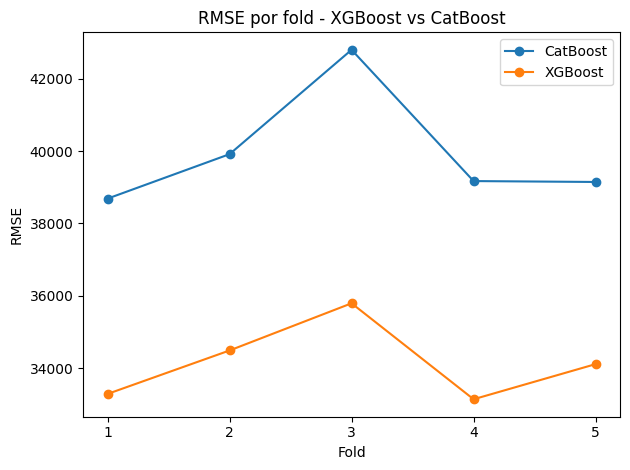


Resumen promedio por modelo:
     modelo      MAE_mean     RMSE_mean   R2_mean
0   XGBoost  20517.193658  34162.256863  0.894926
1  CatBoost  25982.457773  39943.680812  0.856430


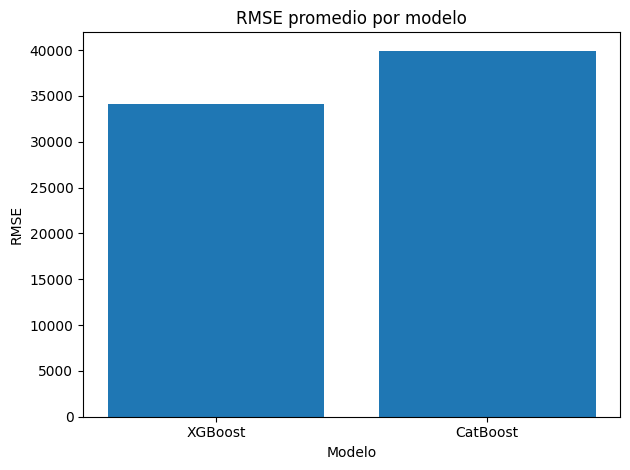

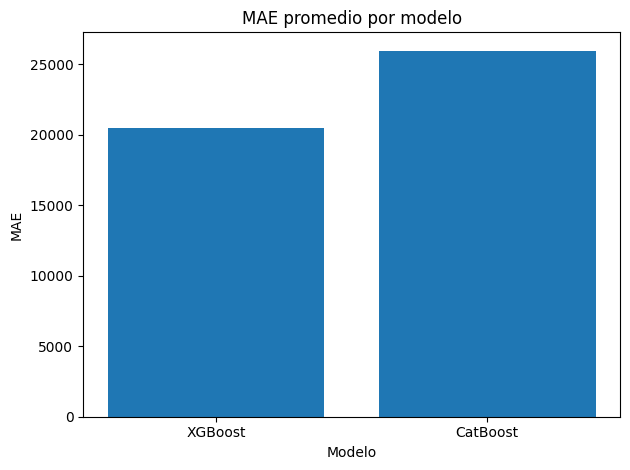

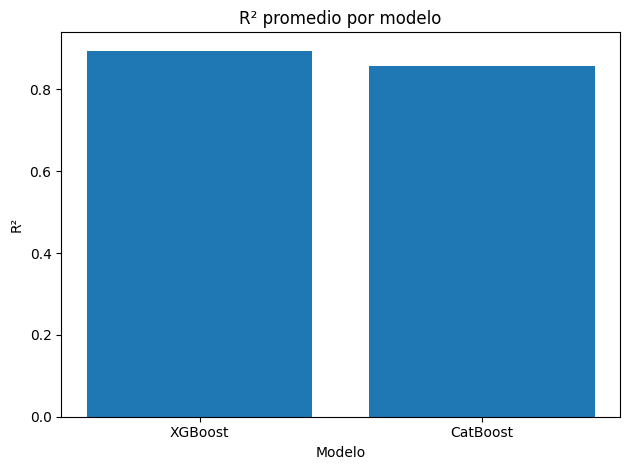

In [11]:
"""# BLOQUE 3c – Visualización de métricas de Cross-Validation"""

import matplotlib.pyplot as plt

# ============================
# 1) DataFrames por fold
# ============================

n_folds = metrics_xgb.shape[0]
folds = np.arange(1, n_folds + 1)

df_xgb = pd.DataFrame(
    metrics_xgb,
    columns=["MAE", "RMSE", "R2"]
)
df_xgb["modelo"] = "XGBoost"
df_xgb["fold"] = folds

df_cat = pd.DataFrame(
    metrics_cat,
    columns=["MAE", "RMSE", "R2"]
)
df_cat["modelo"] = "CatBoost"
df_cat["fold"] = folds

df_metrics_folds = pd.concat([df_xgb, df_cat], ignore_index=True)

print("\nMétricas por fold:")
print(df_metrics_folds.sort_values(["modelo", "fold"]))


# ============================
# 2) Gráfico: RMSE por fold
# ============================

plt.figure()
for modelo, df_m in df_metrics_folds.groupby("modelo"):
    df_m = df_m.sort_values("fold")
    plt.plot(df_m["fold"], df_m["RMSE"], marker="o", label=modelo)

plt.title("RMSE por fold - XGBoost vs CatBoost")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.xticks(folds)
plt.legend()
plt.tight_layout()
plt.savefig("rmse_por_fold.png", dpi=150)
plt.show()


# ============================
# 3) Resumen promedio por modelo
# ============================

resumen = []
for name, m in [("XGBoost", metrics_xgb), ("CatBoost", metrics_cat)]:
    mae_mean, mae_std   = m[:, 0].mean(), m[:, 0].std()
    rmse_mean, rmse_std = m[:, 1].mean(), m[:, 1].std()
    r2_mean, r2_std     = m[:, 2].mean(),  m[:, 2].std()

    resumen.append({
        "modelo": name,
        "MAE_mean": mae_mean,
        "RMSE_mean": rmse_mean,
        "R2_mean": r2_mean
    })

df_resumen = pd.DataFrame(resumen)
print("\nResumen promedio por modelo:")
print(df_resumen)


# ============================
# 4) Gráfico: RMSE promedio por modelo
# ============================

plt.figure()
plt.bar(df_resumen["modelo"], df_resumen["RMSE_mean"])
plt.title("RMSE promedio por modelo")
plt.ylabel("RMSE")
plt.xlabel("Modelo")
plt.tight_layout()
plt.savefig("rmse_promedio_por_modelo.png", dpi=150)
plt.show()


# ============================
# 5) Gráfico: MAE promedio por modelo
# ============================

plt.figure()
plt.bar(df_resumen["modelo"], df_resumen["MAE_mean"])
plt.title("MAE promedio por modelo")
plt.ylabel("MAE")
plt.xlabel("Modelo")
plt.tight_layout()
plt.savefig("mae_promedio_por_modelo.png", dpi=150)
plt.show()


# ============================
# 6) Gráfico: R² promedio por modelo
# ============================

plt.figure()
plt.bar(df_resumen["modelo"], df_resumen["R2_mean"])
plt.title("R² promedio por modelo")
plt.ylabel("R²")
plt.xlabel("Modelo")
plt.tight_layout()
plt.savefig("r2_promedio_por_modelo.png", dpi=150)
plt.show()


# **BLOQUE 4 – Export de modelo + artefactos (para producción / Streamlit)**

In [8]:
# BLOQUE 4 - Entrenar modelo final (XGBoost) con TODO el dataset y exportar artefactos

import pickle
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

SEED = 42

# =====================================================
# 1) Partimos de los datos ya preparados en el bloque de CV
#    - df_cv: dataset limpio (surface_total>0, precio>0, sin outliers fuertes)
#    - X_all: features base
#    - y_all: precio
# =====================================================

X_full_base = X_all.copy()
y_full = y_all.copy()

print("Filas usadas para entrenar el modelo final:", len(X_full_base))

# =====================================================
# 2) Función para armar features completos (sin leakage)
#    sobre TODO el dataset (para producción)
# =====================================================

def build_features_full(X_base, y, n_clusters=6):
    """
    Crea:
      - precio_m2_barrio_full
      - zona_premium_full
      - cluster_geo (KMeans final)
    y devuelve:
      - X_full_xgb: matriz lista para XGBoost (one-hot)
      - kmeans_final
      - precio_m2_barrio_full (Series por barrio)
      - barrio_zona_full (Series por barrio)
    """
    # ---- precio_m2_barrio_full ----
    aux = X_base.copy()
    aux["price"] = y
    aux = aux[aux["surface_total"] > 0].copy()
    aux["precio_m2_real"] = aux["price"] / aux["surface_total"]

    precio_m2_barrio_full = (
        aux.groupby("l3")["precio_m2_real"]
           .median()
    )

    global_med_full = precio_m2_barrio_full.median()

    X_feat = X_base.copy()
    X_feat["precio_m2_barrio"] = (
        X_feat["l3"].map(precio_m2_barrio_full)
                    .fillna(global_med_full)
    )

    # ---- zona_premium_full (0–3 por percentiles de precio_m2_barrio) ----
    barrio_zona_full = pd.qcut(
        precio_m2_barrio_full,
        q=4,
        labels=[0, 1, 2, 3]
    ).astype(int)

    X_feat["zona_premium"] = (
        X_feat["l3"].map(barrio_zona_full)
                    .fillna(1)
                    .astype(int)
    )

    # ---- cluster_geo final (KMeans sobre lat/lon de TODO el dataset) ----
    kmeans_final = KMeans(n_clusters=n_clusters, random_state=SEED)
    kmeans_final.fit(X_feat[["lat", "lon"]])
    X_feat["cluster_geo"] = kmeans_final.labels_

    # ---- One-hot encoding para XGBoost ----
    X_full_xgb = pd.get_dummies(
        X_feat,
        columns=["property_type", "l3", "cluster_geo"],
        drop_first=True
    )

    return X_full_xgb, kmeans_final, precio_m2_barrio_full, barrio_zona_full

# Construimos las features finales
X_full_xgb, kmeans_final, precio_m2_barrio_full, barrio_zona_full = build_features_full(
    X_full_base,
    y_full,
    n_clusters=6
)

print("Shape X_full_xgb (dataset final para producción):", X_full_xgb.shape)

# =====================================================
# 3) Entrenar modelo XGBoost final con TODO el dataset
#    (mismos hiperparámetros que mejor rindieron en CV)
# =====================================================

xgb_final = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    random_state=SEED
)

xgb_final.fit(X_full_xgb, y_full)

# =====================================================
# 4) Exportar modelo y artefactos para producción / Streamlit
# =====================================================

# 4.1 Modelo XGBoost final
with open("modelo_xgboost_final.pkl", "wb") as f:
    pickle.dump(xgb_final, f)

# 4.2 KMeans de clusters geográficos
with open("kmeans_final.pkl", "wb") as f:
    pickle.dump(kmeans_final, f)

# 4.3 Mapping precio m2 barrio (calculado en TODO el dataset)
with open("precio_m2_barrio_final.pkl", "wb") as f:
    pickle.dump(precio_m2_barrio_full, f)

# 4.4 Mapping de zona socioeconómica (0–3) por barrio
with open("zona_premium_map_final.pkl", "wb") as f:
    pickle.dump(barrio_zona_full, f)

# 4.5 Columnas del dataset para XGBoost (para rearmar el DataFrame en predict.py)
with open("xgb_feature_names.pkl", "wb") as f:
    pickle.dump(X_full_xgb.columns.tolist(), f)

print("Modelos y artefactos exportados correctamente:")
print(" - modelo_xgboost_final.pkl")
print(" - kmeans_final.pkl")
print(" - precio_m2_barrio_final.pkl")
print(" - zona_premium_map_final.pkl")
print(" - xgb_feature_names.pkl")


Filas usadas para entrenar el modelo final: 71718
Shape X_full_xgb (dataset final para producción): (71718, 75)
Modelos y artefactos exportados correctamente:
 - modelo_xgboost_final.pkl
 - kmeans_final.pkl
 - precio_m2_barrio_final.pkl
 - zona_premium_map_final.pkl
 - xgb_feature_names.pkl
